In [1]:
# ПОСТАНОВКА ЗАДАЧИ
# На основании данных о пассажирах, которые воспользовались метро дважды за сутки, 
# при наличии информации о первом заходе в метро, необходимо предсказать, 
# на какой станции и через какой промежуток времени, этот пассажир воспользуется метро повторно. 
# В данных присутствуют только те люди, которые совершили ровно две поездки в день, 
# при этом статистика валидаций взята за несколько дней. 

# id - уникальный идентификатор столбца; 
# ticket_id - уникальный идентификатор билета, считается, что у одного билета один владелец 
# ticket_type_nm - тип билета 
# entrance_id - уникальный id входа в станцию 
# entrance_nm - наименование 
# station_id - уникальное id станции захода 
# station_nm - наименование станции захода 
# line_id - уникальный id ветки, на которой находится станция 
# line_nm - наименование ветки, на которой находится станция 
# pass_dttm - дата валидации 
# time_to_under (столбец для предсказания) - сколько времени прошло между первой и второй валидацией;
# label (столбец для предсказания) - id второй станции, на которой произошла валидация 

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np

In [3]:
# DATA PREPORATION
# Подготовка данных. Импорт и просмотр данных
df = pd.read_csv('train_dataset_train.csv')
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA964B2C40>]],
      dtype=object)

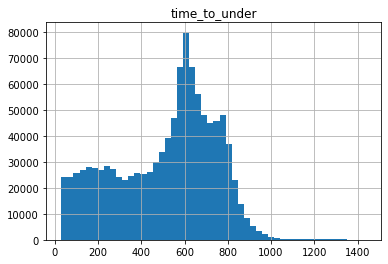

In [4]:
# График количества времени, прошедшего между первой и второй валидациями
df.hist(column = 'time_to_under', bins = 50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FA952409A0>]],
      dtype=object)

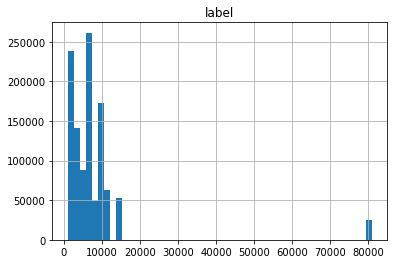

In [5]:
# График количества повторений id второй станции, на которой произошла валидация
df.hist(column = 'label', bins = 50)

In [6]:
# Удаление столбеца ticket_id, так как он индивидуален для каждого билета, а тогда к нему не применить задачу классификации и регрессии.
# Удаление entrance_id, station_id, line_id, т.к. эти столбцы дублируют информацию в соответствующих им столбцах с названием.
# Данные об entrance_nm лишние, так как требуется только название станции, где пассажир воспользуется метро повторно. 

df = df.drop(['id', 'ticket_id', 'entrance_id', 'station_id', 'line_id', 'entrance_nm'], axis=1)
df.head(5)

,ticket_type_nm,station_nm,line_nm,pass_dttm,time_to_under,label
0,Пропуск FacePay,Лефортово,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,СК учащегося 30 дней,Войковская,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,БСК дружинника г.Москвы,Войковская,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,30 дней,Войковская,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,КОШЕЛЕК,Войковская,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


In [7]:
# Проверка на наличие nan в данных
df.isna().sum()

ticket_type_nm    0
station_nm        0
line_nm           0
pass_dttm         0
time_to_under     0
label             0
dtype: int64

In [8]:
# FEATURE INGINEERING
# Конструирование признаков
# Вывод массива и количества уникальных значений среди типов билетов
df.ticket_type_nm.unique()

array(['Пропуск FacePay', 'СК учащегося 30 дней',
       'БСК дружинника г.Москвы', '30 дней', 'КОШЕЛЕК',
       'СК студента 30 дней', '90 дней', '90 дней ЕДИНЫЙ ТК',
       '30 дней СК учащегося', '90 дней СК студента',
       '30 дней СК студента', 'ББК', 'СК аспиранта 90 дней',
       'Социальная карта москвича', '30 дней ЕДИНЫЙ ТК',
       'Социальная карта жителя Моск. области', '30 дней Пригород ТК',
       'Социальная карта москвича с сопровождающим',
       'Пропуск сотрудника УВД по охране Метрополитена',
       '60 поездок ЕДИНЫЙ ТК', 'СК для сотрудника ГУВД г.Москвы',
       '365 дней ЕДИНЫЙ ТК', 'ВЕСБ МОСКВА (7мин)', 'СК студента 90 дней',
       '90 дней Пригород ТК', '30 дней  Пригород', '365 дней Пригород ТК',
       '365 дней', 'СК ординатора 30 дней', '30 дней СК аспиранта',
       '30 дней СК ординатора', '90 дней СК ординатора',
       'ВЕСБ МО (7 мин)', 'ВЕСБ МО (тип 5)', 'СК ординатора 90 дней',
       'СК аспиранта 30 дней', '90 дней СК учащегося',
       'Времен

In [9]:
df.ticket_type_nm.nunique()

60

In [10]:
# Замена дублирующихся названий
df.replace({'30 дней СК учащегося':'СК учащегося 30 дней', 
              '30 дней СК студента': 'СК студента 30 дней',
              '90 дней СК студента':'СК студента 90 дней',
              '90 дней СК учащегося':'СК учащегося 90 дней',
              '3 суток Единый ТК':'Билет 3 суток ЕДИНЫЙ',
              '30 дней СК ассистента-стажера':'СК ассистента-стажера 30 дней',
              '90 дней СК аспиранта':'СК аспиранта 90 дней',
              '30 дней СК аспиранта':'СК аспиранта 30 дней',
              '90 дней СК аспиранта':'СК аспиранта 90 дней',
              '30 дней СК ординатора':'СК ординатора 30 дней',
              '90 дней СК ординатора':'СК ординатора 90 дней'}, inplace=True)
df.ticket_type_nm.unique()

array(['Пропуск FacePay', 'СК учащегося 30 дней',
       'БСК дружинника г.Москвы', '30 дней', 'КОШЕЛЕК',
       'СК студента 30 дней', '90 дней', '90 дней ЕДИНЫЙ ТК',
       'СК студента 90 дней', 'ББК', 'СК аспиранта 90 дней',
       'Социальная карта москвича', '30 дней ЕДИНЫЙ ТК',
       'Социальная карта жителя Моск. области', '30 дней Пригород ТК',
       'Социальная карта москвича с сопровождающим',
       'Пропуск сотрудника УВД по охране Метрополитена',
       '60 поездок ЕДИНЫЙ ТК', 'СК для сотрудника ГУВД г.Москвы',
       '365 дней ЕДИНЫЙ ТК', 'ВЕСБ МОСКВА (7мин)', '90 дней Пригород ТК',
       '30 дней  Пригород', '365 дней Пригород ТК', '365 дней',
       'СК ординатора 30 дней', 'СК аспиранта 30 дней',
       'СК ординатора 90 дней', 'ВЕСБ МО (7 мин)', 'ВЕСБ МО (тип 5)',
       'СК учащегося 90 дней', 'Временный билет ММ',
       'Социальная карта жителя Моск. области с сопровождающим',
       'Билет 3 суток ЕДИНЫЙ', 'Пропуск сотрудника  метрополитена',
       'ВЕСБ МОСК

In [11]:
df.ticket_type_nm.nunique()

50

In [12]:
# Распределение наименований билетов по общим признакам по роду деятельности, 
# с целью уменьшить число категориальных признаков и повысить точность алгоритма.

student = ['СК учащегося 30 дней', 'СК студента 30 дней', 'СК студента 90 дней', 'СК аспиранта 90 дней', 'СК ординатора 30 дней',
           'СК аспиранта 30 дней', 'СК ординатора 90 дней', 'СК учащегося 90 дней', 'СК ассистента-стажера 30 дней', 
           'СК ассистента-стажера 90 дней']

# Замена значений в массиве
df.loc[df['ticket_type_nm'].isin(student), 'ticket_type_nm'] = 'student'

In [13]:
subway = ['Пропуск сотрудника УВД по охране Метрополитена', 'Пропуск сотрудника  метрополитена',
          'Пропуск руководителя метрополитена', 'Пропуск  сотрудника МЦК']

df.loc[df['ticket_type_nm'].isin(subway), 'ticket_type_nm'] = 'subway'

In [14]:
travel = ['Билет 3 суток ЕДИНЫЙ','1 сутки ЕДИНЫЙ ТК','1 сутки Пригород ТК','Билет 1 сутки ЕДИНЫЙ']

df.loc[df['ticket_type_nm'].isin(travel), 'ticket_type_nm'] = 'travel'

In [15]:
# Соц. карты
# ВЕСБ - временный единый социальный билет, ВЛБ - временный льготный билет.

concessional = ['Социальная карта москвича','Социальная карта жителя Моск. области',
                'Социальная карта москвича с сопровождающим','ВЕСБ МО (7 мин)', 'ВЕСБ МО (тип 5)', 'ВЕСБ МОСКВА (7мин)',
                'Социальная карта жителя Моск. области с сопровождающим','ВЕСБ МОСКВА','ВЛБ МОСКВА', 'ВЕСБ МО с сопровождающим',
                'ВЕСБ МО (тип 6)']

df.loc[df['ticket_type_nm'].isin(concessional), 'ticket_type_nm'] = 'concessional'

In [16]:
# Те, кто пользуется метро регулярно для поездки на работу, обычно покупают билеты минимум на 30 дней.

work = ['БСК дружинника г.Москвы','30 дней', '90 дней', '90 дней ЕДИНЫЙ ТК', '30 дней ЕДИНЫЙ ТК',
        '30 дней Пригород ТК','60 поездок ЕДИНЫЙ ТК', 'СК для сотрудника ГУВД г.Москвы','365 дней ЕДИНЫЙ ТК',
        '90 дней Пригород ТК','30 дней  Пригород', '365 дней Пригород ТК', '365 дней','Безналичная транспортная карта',
        '90 дней  Пригород', 'Ультралайт Единый (70)','365 дней  Пригород']

df.loc[df['ticket_type_nm'].isin(work), 'ticket_type_nm'] = 'work'

In [17]:
# Те, кто оплачивают метро по банковской карте, вероятно, не ездят на работу на данном виде транспорта.
# ББК - бесконтактная банковская карта, ММ - метро Москвы.

one_use = ['Пропуск FacePay','КОШЕЛЕК','ББК','Временный билет ММ']

df.loc[df['ticket_type_nm'].isin(one_use), 'ticket_type_nm'] = 'one_use'

df.ticket_type_nm.unique()

array(['one_use', 'student', 'work', 'concessional', 'subway', 'travel'],
      dtype=object)

In [18]:
# Далее вводится буквенное обозначение для времени, чтобы большая дата и время не соотносились с важностью признака.
# Импорт библиотеки для работы со временем.

from datetime import datetime

df['pass_dttm'] = pd.to_datetime(df['pass_dttm'])

# Номер дня недели
df['day'] = df.pass_dttm.dt.dayofweek

# Номер часа (от 0 до 24)
df['hour'] = df.pass_dttm.dt.hour 
df

,ticket_type_nm,station_nm,line_nm,pass_dttm,time_to_under,label,day,hour
0,one_use,Лефортово,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,0,5
1,student,Войковская,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,0,5
2,work,Войковская,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,0,5
3,work,Войковская,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022,0,5
4,one_use,Войковская,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017,0,5
...,...,...,...,...,...,...,...,...
1091016,one_use,Нижегородская,Некрасовская,2022-09-19 02:54:50,124.750000,15005,0,2
1091017,one_use,Калужская,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007,0,3
1091018,one_use,Каширская,Замоскворецкая,2022-09-19 03:17:00,91.283333,2010,0,3
1091019,one_use,Воронцовская,Большая кольцевая,2022-09-19 03:23:30,47.900000,11014,0,3


In [19]:
# Проверка, за сколько дней была предоставлена статистика
df.day.unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [20]:
# Так как числу 0 сопоставлено 12 сентября 2022г., то 17 и 18 сентября, т.е. числа 5 и 6, - выходные.

# Определение, является день рабочим или нет.
df['workday'] = df['day'].apply(lambda x: 'no' if x == 5 or x == 6 else 'yes')

# Численное обозначение часов сопоставим со временем суток, когда пассажиры активны.
df['hour_explained'] = df['hour'].apply(lambda x: 'morning' if 5 <= x < 10 else (
        'day' if 10 <= x < 17 else ('evening' if 17 <= x < 23 else ('night' if x >= 23 else('night'if 0 <= x < 5 else x)))))
df

,ticket_type_nm,station_nm,line_nm,pass_dttm,time_to_under,label,day,hour,workday,hour_explained
0,one_use,Лефортово,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,0,5,yes,morning
1,student,Войковская,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,0,5,yes,morning
2,work,Войковская,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,0,5,yes,morning
3,work,Войковская,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022,0,5,yes,morning
4,one_use,Войковская,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017,0,5,yes,morning
...,...,...,...,...,...,...,...,...,...,...
1091016,one_use,Нижегородская,Некрасовская,2022-09-19 02:54:50,124.750000,15005,0,2,yes,night
1091017,one_use,Калужская,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007,0,3,yes,night
1091018,one_use,Каширская,Замоскворецкая,2022-09-19 03:17:00,91.283333,2010,0,3,yes,night
1091019,one_use,Воронцовская,Большая кольцевая,2022-09-19 03:23:30,47.900000,11014,0,3,yes,night


In [21]:
df=df.drop(['pass_dttm', 'hour','day'], axis=1)
df

,ticket_type_nm,station_nm,line_nm,time_to_under,label,workday,hour_explained
0,one_use,Лефортово,Большая кольцевая,216.316667,8001,yes,morning
1,student,Войковская,Замоскворецкая,648.183333,9011,yes,morning
2,work,Войковская,Замоскворецкая,865.333333,7022,yes,morning
3,work,Войковская,Замоскворецкая,1048.233333,2022,yes,morning
4,one_use,Войковская,Замоскворецкая,965.600000,2017,yes,morning
...,...,...,...,...,...,...,...
1091016,one_use,Нижегородская,Некрасовская,124.750000,15005,yes,night
1091017,one_use,Калужская,Калужско-Рижская,56.066667,6007,yes,night
1091018,one_use,Каширская,Замоскворецкая,91.283333,2010,yes,night
1091019,one_use,Воронцовская,Большая кольцевая,47.900000,11014,yes,night


In [22]:
# Кодировка категориальных признаков с использованием методов FeatureHasher и OneHotEncoder

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder

# Признаков мало (6 типов), значит подходит OneHotEncoder
ticket_type_new = OneHotEncoder(handle_unknown='ignore')
df1 = pd.DataFrame(ticket_type_new.fit_transform(df[['ticket_type_nm']]).toarray())

# Признаков много (250 станций), подходит FeatureHasher
station_new = FeatureHasher(n_features=35, input_type='string')
df2 = pd.DataFrame(station_new.fit_transform(df['station_nm']).toarray())

line_new = FeatureHasher(n_features=15, input_type='string')
df3 =  pd.DataFrame(line_new.fit_transform(df['line_nm']).toarray())

workday_new = OneHotEncoder(handle_unknown='ignore')
df4 = pd.DataFrame(workday_new.fit_transform(df[['workday']]).toarray())

hour_new = OneHotEncoder(handle_unknown='ignore')
df5 = pd.DataFrame(hour_new.fit_transform(df[['hour_explained']]).toarray())

# Объединение полученных датафреймов
df = pd.concat([df, df1, df2, df3, df4, df5], axis=1)

In [23]:
df = df.drop(['ticket_type_nm', 'station_nm', 'line_nm', 'workday', 'hour_explained'], axis=1)
df

,time_to_under,label,0,1,2,3,4,5,0,1,...,11,12,13,14,0,1,0,1,2,3
0,216.316667,8001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.0,0.0,1.0,0.0,0.0,1.0,0.0
1,648.183333,9011,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,-1.0,-2.0,0.0,1.0,0.0,0.0,1.0,0.0
2,865.333333,7022,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,...,0.0,0.0,-1.0,-2.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1048.233333,2022,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,...,0.0,0.0,-1.0,-2.0,0.0,1.0,0.0,0.0,1.0,0.0
4,965.600000,2017,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,-1.0,-2.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,124.750000,15005,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,-1.0,-2.0,0.0,1.0,0.0,0.0,0.0,1.0
1091017,56.066667,6007,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,-1.0,0.0,-3.0,-2.0,0.0,1.0,0.0,0.0,0.0,1.0
1091018,91.283333,2010,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,-1.0,-2.0,0.0,1.0,0.0,0.0,0.0,1.0
1091019,47.900000,11014,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,0.0,0.0,-2.0,0.0,1.0,0.0,0.0,0.0,1.0


In [24]:
# Импорт библиотек для создания тестовой и тренировочной выборки, метода линейной регрессии и оценки точности
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df.drop(['time_to_under', 'label'], axis=1)
y = df['time_to_under']

# Разделение данных на тестовую и тренировочную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Тренировка модели методом линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Проверка на тестовой выборке
y_predict = model.predict(X_test)

# Оценка точности (коэффициент детерминации)
r2 = r2_score(y_test, y_predict)
r2

0.44105309766063394

In [25]:
# Импорт библиотеки для решения задачи методом классификации (решающие деревья) и оценки точности
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

X = df.drop(['time_to_under','label'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Метод решающих деревьев
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

# Метрика ошибок
recall = recall_score(y_test, y_predict, average='micro')
recall

0.06501541366362468

In [26]:
# Результат
result = 0.5 * recall + 0.5 * r2
print('result: ' + str(result))

result: 0.25303425566212934
